In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os

In [2]:
def get_annotations(data, img_path):
    category_names=set()
    annotations = []
    for i in range(len(data)):
        ann=np.array(data.loc[i,"labels"].split(" ")).reshape(-1,5)#cat,x,y,width,height for each picture
        category_names=category_names.union({i for i in ann[:,0]})

    category_names=sorted(category_names)
    dict_cat={list(category_names)[j]:str(j) for j in range(len(category_names))}
    inv_dict_cat={str(j):list(category_names)[j] for j in range(len(category_names))}
    #print(dict_cat)
    
    for i in range(len(data)):
        ann=np.array(data.loc[i,"labels"].split(" ")).reshape(-1,5)#cat,left,top,width,height for each picture
        for j,category_name in enumerate(ann[:,0]):
            ann[j,0]=int(dict_cat[category_name])  
        ann=ann.astype('int32')
        ann[:,1]+=ann[:,3]//2#center_x
        ann[:,2]+=ann[:,4]//2#center_y
        annotations.append(["{}{}.jpg".format(img_path,data.loc[i,"image_id"]),ann])
    return annotations #cat,center x,center y,width,height for each picture

sample image


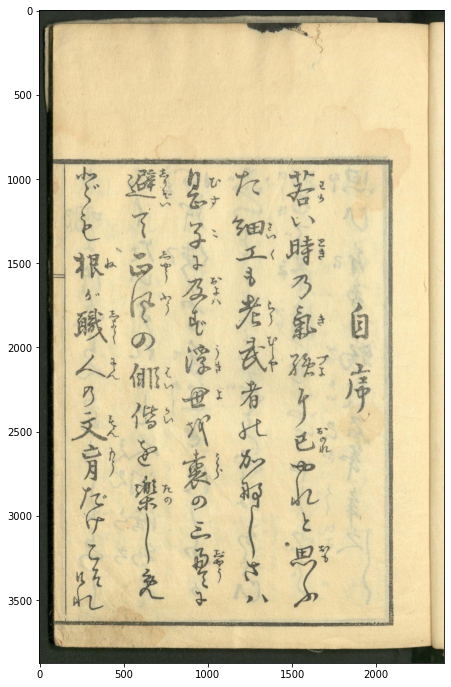

In [4]:
root_dir = '/home/mauricio/Documents/Pytorch/mmdetection/mmdetection_mau/data/kuzushiji/' #Nancho_dataset, S05_Detection&Recognition
path_2=root_dir+"/train_images/"
path_3=root_dir+"/test_images/"
path_4=root_dir+"/sample_submission.csv"

df_train=pd.read_csv(root_dir+'/train.csv')
#print(df_train.head())
#print(df_train.shape)
df_train=df_train.dropna(axis=0, how='any')#you can use nan data(page with no letter)
df_train=df_train.reset_index(drop=True)
#print(df_train.shape)

annotation_list_train=get_annotations(df_train, path_2)
print("sample image")
input_width,input_height=1024, 1024
img = np.asarray(Image.open(annotation_list_train[0][0]).convert('RGB')) #.resize((input_width,input_height)).
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.show()

In [5]:
print(annotation_list_train[0][0])
print(annotation_list_train[0][1][2])
annotation_list_train[0][1][:,3]

/home/mauricio/Documents/Pytorch/mmdetection/mmdetection_mau/data/kuzushiji//train_images/100241706_00004_2.jpg
[  39 1566 1252  143   69]


array([133,  84, 143,  53,  61,  71,  95, 187,  69, 121, 141, 151,  55,
       127,  72,  95,  68, 169, 163, 200,  57, 183, 112, 181, 159, 163,
       123, 145,  97, 176, 184, 156, 156, 168, 100, 117, 151, 133, 103,
       181, 136, 216, 147, 168, 159, 135, 151, 155, 145, 145, 197, 152,
       171, 133, 116, 119, 172, 104, 139, 147,  83, 169, 103, 123, 152,
        27,  39], dtype=int32)

check character size

In [8]:
aspect_ratio_pic_all=[]
aspect_ratio_pic_all_test=[]
train_avg_letter_size_all=[]
train_input_for_size_estimate=[]
test_avg_letter_size_all=[]
test_input_for_size_estimate=[]
resize_dir=root_dir+"resized/"
sizes_train =[[],[],[]]
sizes_test =[[],[],[]]


# if os.path.exists(resize_dir) == False:os.mkdir(resize_dir)
for i in range(len(annotation_list_train)):
    with Image.open(annotation_list_train[i][0]) as f: #read img file
        width,height=f.size
        area=width*height
        aspect_ratio_pic=height/width
        aspect_ratio_pic_all.append(aspect_ratio_pic)
        letter_size=annotation_list_train[i][1][:,3]*annotation_list_train[i][1][:,4]
        letter_size_ratio=letter_size/area
        for j in letter_size:
            if j < 32**2:
                sizes_train[0].append(j)
            elif (j>32**2) and (j<96**2):
                sizes_train[1].append(j)
            elif j > 96**2:
                sizes_train[2].append(j)
    
        average_letter_size=np.mean(letter_size_ratio)
        train_avg_letter_size_all.append(average_letter_size)
        train_input_for_size_estimate.append([annotation_list_train[i][0],np.log(average_letter_size)])#logにしとく
    
# get directory of test images
df_submission=pd.read_csv(path_4)
df_test=df_submission.reset_index(drop=True)
annotation_list_test=get_annotations(df_test, path_2)

id_test=path_3+df_submission["image_id"]+".jpg"
for i in range(len(id_test)):
    with Image.open(id_test[i]) as f:
        width,height=f.size
        area=width*height
        aspect_ratio_pic=height/width
        aspect_ratio_pic_all_test.append(aspect_ratio_pic)
        letter_size=annotation_list_test[i][1][:,3]*annotation_list_test[i][1][:,4]
        letter_size_ratio=letter_size/area
        for j in letter_size:
            if j < 32**2:
                sizes_test[0].append(j)
            elif (j>32**2) and (j<96**2):
                sizes_test[1].append(j)
            elif j > 96**2:
                sizes_test[2].append(j)
    
        average_letter_size=np.mean(letter_size_ratio)
        test_avg_letter_size_all.append(average_letter_size)
        test_input_for_size_estimate.append([annotation_list_test[i][0],np.log(average_letter_size)])#logにしとく


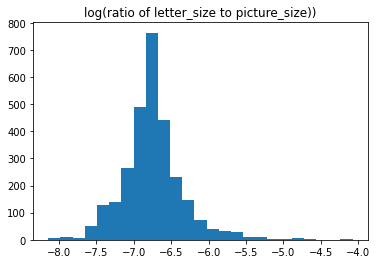

In [10]:
plt.hist(np.log(train_avg_letter_size_all),bins=25)
plt.title('log(ratio of letter_size to picture_size))',loc='center',fontsize=12)
plt.show()

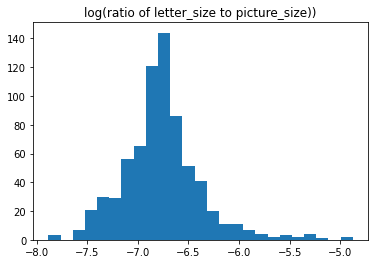

In [11]:
plt.hist(np.log(test_avg_letter_size_all),bins=25)
plt.title('log(ratio of letter_size to picture_size))',loc='center',fontsize=12)
plt.show()

In [12]:
len(sizes_train[2]) #[0, 4822, 18222]
len(sizes_test[0]) #[0, 1253, 7376]
print(np.mean(train_avg_letter_size_all))
print(np.mean(test_avg_letter_size_all))

0.0012955135410188021
0.0012617631635926006


In [13]:
for i in sizes_train:
    print(len(i))
print('--')
for i in sizes_test:
    print(len(i))

3856
386610
154165
--
976
97459
40151


In [70]:
# sizes_test[0]

In [28]:
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout, Conv2D,Conv2DTranspose, BatchNormalization, Activation,AveragePooling2D,GlobalAveragePooling2D, Input, Concatenate, MaxPool2D, Add, UpSampling2D, LeakyReLU,ZeroPadding2D
from keras.models import Model
from keras.metrics import mean_squared_error
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
import os  

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# from keras.optimizers import Adam, RMSprop, SGD
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

category_n=1
input_width,input_height=1024, 1024
category_n=1
output_layer_n=category_n+4

def Datagen_sizecheck_model(filenames, batch_size, size_detection_mode=True, is_train=True,random_crop=True):
  x=[]
  y=[]
  
  count=0

  while True:
    for i in range(len(filenames)):
      if random_crop:
        crop_ratio=np.random.uniform(0.7,1)
      else:
        crop_ratio=1
      with Image.open(filenames[i][0]) as f:
        #random crop
        if random_crop and is_train:
          pic_width,pic_height=f.size
          f=np.asarray(f.convert('RGB'),dtype=np.uint8)
          top_offset=np.random.randint(0,pic_height-int(crop_ratio*pic_height))
          left_offset=np.random.randint(0,pic_width-int(crop_ratio*pic_width))
          bottom_offset=top_offset+int(crop_ratio*pic_height)
          right_offset=left_offset+int(crop_ratio*pic_width)
          f=cv2.resize(f[top_offset:bottom_offset,left_offset:right_offset,:],(input_height,input_width))
        else:
          f=f.resize((input_width, input_height))
          f=np.asarray(f.convert('RGB'),dtype=np.uint8)          
        x.append(f)
      
      
      if random_crop and is_train:
        y.append(filenames[i][1]-np.log(crop_ratio))
      else:
        y.append(filenames[i][1])
      
      count+=1
      if count==batch_size:
        x=np.array(x, dtype=np.float32)
        y=np.array(y, dtype=np.float32)

        inputs=x/255
        targets=y       
        x=[]
        y=[]
        count=0
        yield inputs, targets



def aggregation_block(x_shallow, x_deep, deep_ch, out_ch):
  x_deep= Conv2DTranspose(deep_ch, kernel_size=2, strides=2, padding='same', use_bias=False)(x_deep)
  x_deep = BatchNormalization()(x_deep)   
  x_deep = LeakyReLU(alpha=0.1)(x_deep)
  x = Concatenate()([x_shallow, x_deep])
  x=Conv2D(out_ch, kernel_size=1, strides=1, padding="same")(x)
  x = BatchNormalization()(x)   
  x = LeakyReLU(alpha=0.1)(x)
  return x
  


def cbr(x, out_layer, kernel, stride):
  x=Conv2D(out_layer, kernel_size=kernel, strides=stride, padding="same")(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)
  return x

def resblock(x_in,layer_n):
  x=cbr(x_in,layer_n,3,1)
  x=cbr(x,layer_n,3,1)
  x=Add()([x,x_in])
  return x  


#I use the same network at CenterNet
def create_model(input_shape, size_detection_mode=True, aggregation=True):
    input_layer = Input(input_shape)
    
    #resized input
    input_layer_1=AveragePooling2D(2)(input_layer)
    input_layer_2=AveragePooling2D(2)(input_layer_1)

    #### ENCODER ####

    x_0= cbr(input_layer, 16, 3, 2)#512->256
    concat_1 = Concatenate()([x_0, input_layer_1])

    x_1= cbr(concat_1, 32, 3, 2)#256->128
    concat_2 = Concatenate()([x_1, input_layer_2])

    x_2= cbr(concat_2, 64, 3, 2)#128->64
    
    x=cbr(x_2,64,3,1)
    x=resblock(x,64)
    x=resblock(x,64)
    
    x_3= cbr(x, 128, 3, 2)#64->32
    x= cbr(x_3, 128, 3, 1)
    x=resblock(x,128)
    x=resblock(x,128)
    x=resblock(x,128)
    
    x_4= cbr(x, 256, 3, 2)#32->16
    x= cbr(x_4, 256, 3, 1)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
 
    x_5= cbr(x, 512, 3, 2)#16->8
    x= cbr(x_5, 512, 3, 1)
    
    x=resblock(x,512)
    x=resblock(x,512)
    x=resblock(x,512)
    
    if size_detection_mode:
      x=GlobalAveragePooling2D()(x)
      x=Dropout(0.2)(x)
      out=Dense(1,activation="linear")(x)
    
    else:#centernet mode
    #### DECODER ####
      x_1= cbr(x_1, output_layer_n, 1, 1)
      x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
      x_2= cbr(x_2, output_layer_n, 1, 1)
      x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
      x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
      x_3= cbr(x_3, output_layer_n, 1, 1)
      x_3 = aggregation_block(x_3, x_4, output_layer_n, output_layer_n) 
      x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
      x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
      
      x_4= cbr(x_4, output_layer_n, 1, 1)

      x=cbr(x, output_layer_n, 1, 1)
      x= UpSampling2D(size=(2, 2))(x)#8->16 tconvのがいいか

      x = Concatenate()([x, x_4])
      x=cbr(x, output_layer_n, 3, 1)
      x= UpSampling2D(size=(2, 2))(x)#16->32
    
      x = Concatenate()([x, x_3])
      x=cbr(x, output_layer_n, 3, 1)
      x= UpSampling2D(size=(2, 2))(x)#32->64   128のがいいかも？ 
    
      x = Concatenate()([x, x_2])
      x=cbr(x, output_layer_n, 3, 1)
      x= UpSampling2D(size=(2, 2))(x)#64->128 
      
      x = Concatenate()([x, x_1])
      x=Conv2D(output_layer_n, kernel_size=3, strides=1, padding="same")(x)
      out = Activation("sigmoid")(x)
    
    model=Model(input_layer, out)
    
    return model
  
def lrs(epoch):
    lr = 0.0005
    if epoch>10:
        lr = 0.0001
    return lr

# lr_schedule = LearningRateScheduler(lrs)   
# model_checkpoint = ModelCheckpoint("final_weights_step1.hdf5", monitor = 'val_loss', verbose = 1,
#                                       save_best_only = True, save_weights_only = True, period = 1) 

  

In [29]:
K.clear_session()
model=create_model(input_shape=(input_height,input_width,3),size_detection_mode=True)
"""
# EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta=0, patience = 10, verbose = 1)
# ModelCheckpoint
weights_dir = '/model_1/'
if os.path.exists(weights_dir) == False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(weights_dir + "val_loss{val_loss:.3f}.hdf5", monitor = 'val_loss', verbose = 1,
                                      save_best_only = True, save_weights_only = True, period = 1)
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 10, verbose = 1)
"""

lr_schedule = LearningRateScheduler(lrs)
model_checkpoint = ModelCheckpoint(root_dir+"/final_weights_step1.hdf5", verbose = 1, monitor = 'loss',
                                      save_best_only = True, save_weights_only = True, save_freq = 1) 
# print(model.summary())

2023-01-11 14:35:02.512529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 14:35:02.659494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 14:35:02.659696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 14:35:02.660391: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [30]:
def lrs(epoch):
    lr = 0.0005
    if epoch>10:
        lr = 0.001
    return lr
lr_schedule = LearningRateScheduler(lrs)
def model_fit_sizecheck_model(model,train_list,cv_list,n_epoch,batch_size=32):
    hist = model.fit(
        Datagen_sizecheck_model(train_list,batch_size, is_train=True,random_crop=True),
        steps_per_epoch = len(train_list) // batch_size,
        epochs = n_epoch,
        validation_data=Datagen_sizecheck_model(cv_list,batch_size, is_train=False,random_crop=False),
        validation_steps = len(cv_list) // batch_size,
        callbacks = [lr_schedule, model_checkpoint],#[early_stopping, reduce_lr, model_checkpoint],
        shuffle = True,
        verbose = 1
    )
    return hist

training

In [33]:
from sklearn.model_selection import KFold,train_test_split
train_list, cv_list = train_test_split(train_input_for_size_estimate, random_state = 111,test_size = 0.2)

TRAIN_MODEL= False

learning_rate=0.001
n_epoch=50
batch_size=32

if TRAIN_MODEL:
    model.compile(loss=mean_squared_error, optimizer=SGD(learning_rate=learning_rate)) #optimizer=Adam(learning_rate=learning_rate)
    hist = model_fit_sizecheck_model(model,train_list,cv_list,n_epoch,batch_size)


In [31]:
#model.save_weights('final_weights_step1.h5')
model.load_weights(root_dir+'/final_weights_step1.hdf5')

In [39]:
(target)

[-6.904981470489469,
 -6.655049669391584,
 -7.079263463228418,
 -7.1334701033923835,
 -6.407292207851445,
 -7.6416367672591194,
 -7.628222477450268,
 -7.49701161237686,
 -6.171413058567579,
 -6.754973311400885,
 -7.503761523950086,
 -7.235983816918003,
 -7.072691941652215,
 -7.084374289495643,
 -8.064062163867606,
 -6.735549465164423,
 -6.6937211455876895,
 -7.147642710460638,
 -7.275311117962944,
 -7.677378226430973,
 -4.969929651370456,
 -7.103137760119497,
 -6.796851423222886,
 -6.954834823032949,
 -6.541043696412792]

2023-01-11 14:35:56.244464: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 402653184 exceeds 10% of free system memory.
2023-01-11 14:35:56.454650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-11 14:35:56.798562: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 402653184 exceeds 10% of free system memory.
2023-01-11 14:35:57.946613: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301
2023-01-11 14:35:59.158213: W tensorflow/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-01-11 14:35:59.158226: W tensorflow/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-01-11 14:35:59.158658: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform

ValueError: x and y must be the same size

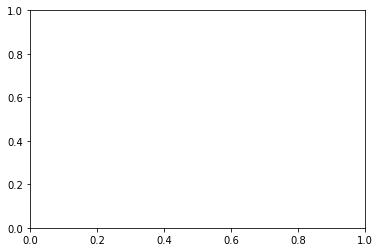

In [34]:
predict = model.predict(Datagen_sizecheck_model(cv_list,batch_size, is_train=False,random_crop=False),
                                steps=2  ) #steps=len(cv_list) // batch_size #len=64
target=[cv[1] for cv in cv_list] #len=25
plt.scatter(predict,target[:len(predict)])
plt.title('---letter_size/picture_size--- estimated vs target ',loc='center',fontsize=10)
plt.show()

In [40]:
predict

array([[-5.5256186],
       [-6.0969257],
       [-5.863373 ],
       [-5.312765 ],
       [-5.6043224],
       [-5.2636456],
       [-5.3422027],
       [-5.383251 ],
       [-5.350436 ],
       [-6.086135 ],
       [-5.87204  ],
       [-5.3837576],
       [-5.706395 ],
       [-6.013805 ],
       [-5.4518785],
       [-6.024383 ],
       [-6.332589 ],
       [-5.527186 ],
       [-5.689289 ],
       [-6.1494293],
       [-5.4608407],
       [-6.217159 ],
       [-5.29987  ],
       [-5.3466506],
       [-6.0480657],
       [-5.5256186],
       [-6.0969257],
       [-5.863373 ],
       [-5.312765 ],
       [-5.6043224],
       [-5.2636456],
       [-5.3422027],
       [-5.383251 ],
       [-5.350436 ],
       [-6.086135 ],
       [-5.87204  ],
       [-5.3837576],
       [-5.706395 ],
       [-6.013805 ],
       [-5.4518785],
       [-6.024383 ],
       [-6.332589 ],
       [-5.527186 ],
       [-5.689289 ],
       [-6.1494293],
       [-5.4608407],
       [-6.217159 ],
       [-5.29